# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape
print 'dev data shape: ', X_dev.shape
print 'dev labels shape: ', y_dev.shape

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [4]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

loss: 2.363253
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *For each images, -log(0.1) means the probability of correct classification is 100%*


In [17]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -4.358877 analytic: -4.358877, relative error: 2.026549e-08
numerical: -0.728733 analytic: -0.728733, relative error: 3.512463e-09


numerical: 1.430128 analytic: 1.430127, relative error: 2.854927e-08
numerical: 1.479355 analytic: 1.479355, relative error: 3.234248e-08


numerical: 1.512907 analytic: 1.512907, relative error: 2.836203e-08
numerical: -0.905342 analytic: -0.905342, relative error: 2.269256e-09


numerical: -1.367204 analytic: -1.367204, relative error: 1.083176e-08
numerical: -0.459972 analytic: -0.459972, relative error: 1.382999e-07


numerical: 1.685120 analytic: 1.685120, relative error: 5.494360e-08
numerical: 1.964869 analytic: 1.964869, relative error: 4.376361e-08


numerical: -0.749410 analytic: -0.749410, relative error: 4.046256e-08
numerical: 0.246794 analytic: 0.246794, relative error: 2.702519e-07


numerical: -1.620979 analytic: -1.620979, relative error: 7.824202e-09
numerical: -0.123130 analytic: -0.123130, relative error: 3.344693e-07


numerical: 3.254547 analytic: 3.254547, relative error: 2.463374e-08
numerical: -0.296178 analytic: -0.296178, relative error: 1.605381e-07


numerical: -2.416638 analytic: -2.416638, relative error: 2.685723e-09
numerical: 0.934577 analytic: 0.934577, relative error: 6.143638e-09


numerical: -2.305241 analytic: -2.305241, relative error: 1.388625e-08
numerical: 2.351587 analytic: 2.351587, relative error: 2.486432e-08


In [20]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

naive loss: 2.363253e+00 computed in 0.091984s
vectorized loss: 2.363253e+00 computed in 0.011394s
Loss difference: 0.000000
Gradient difference: 0.000000


In [28]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7]
regularization_strengths = [2e3, 5e3, 8e3]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for lr in learning_rates:
    for reg in regularization_strengths:
        softmax_temp = Softmax()
        softmax_temp.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=3000, verbose=True)
        train_predict_temp = softmax_temp.predict(X_train)
        val_predict_temp = softmax_temp.predict(X_val)
        train_accuracy_temp = np.mean(y_train == train_predict_temp)
        val_accuracy_temp = np.mean(y_val == val_predict_temp)
        results[(lr, reg)] = (train_accuracy_temp, val_accuracy_temp)
        if best_val < val_accuracy_temp:
            best_val = val_accuracy_temp
            best_softmax = softmax_temp
pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

iteration 0 / 3000: loss 36.958742


iteration 100 / 3000: loss 33.614561


iteration 200 / 3000: loss 31.960129


iteration 300 / 3000: loss 30.445623


iteration 400 / 3000: loss 29.259612


iteration 500 / 3000: loss 28.282037


iteration 600 / 3000: loss 26.795382


iteration 700 / 3000: loss 25.816728


iteration 800 / 3000: loss 24.789093


iteration 900 / 3000: loss 23.853052


iteration 1000 / 3000: loss 22.977595


iteration 1100 / 3000: loss 22.001258


iteration 1200 / 3000: loss 21.402823


iteration 1300 / 3000: loss 20.383935


iteration 1400 / 3000: loss 19.785849


iteration 1500 / 3000: loss 18.853120


iteration 1600 / 3000: loss 18.176476


iteration 1700 / 3000: loss 17.526064


iteration 1800 / 3000: loss 16.894364


iteration 1900 / 3000: loss 16.328946


iteration 2000 / 3000: loss 15.580917


iteration 2100 / 3000: loss 15.151273


iteration 2200 / 3000: loss 14.576648


iteration 2300 / 3000: loss 14.029856


iteration 2400 / 3000: loss 13.568272


iteration 2500 / 3000: loss 13.159213


iteration 2600 / 3000: loss 12.604276


iteration 2700 / 3000: loss 12.166347


iteration 2800 / 3000: loss 11.845044


iteration 2900 / 3000: loss 11.424151


iteration 0 / 3000: loss 83.517225


iteration 100 / 3000: loss 73.358100


iteration 200 / 3000: loss 66.172084


iteration 300 / 3000: loss 59.729456


iteration 400 / 3000: loss 54.390503


iteration 500 / 3000: loss 49.150901


iteration 600 / 3000: loss 44.257525


iteration 700 / 3000: loss 40.238002


iteration 800 / 3000: loss 36.710154


iteration 900 / 3000: loss 33.326620


iteration 1000 / 3000: loss 30.154110


iteration 1100 / 3000: loss 27.463539


iteration 1200 / 3000: loss 24.880384


iteration 1300 / 3000: loss 22.785917


iteration 1400 / 3000: loss 20.704338


iteration 1500 / 3000: loss 19.072676


iteration 1600 / 3000: loss 17.229971


iteration 1700 / 3000: loss 15.844961


iteration 1800 / 3000: loss 14.457052


iteration 1900 / 3000: loss 13.177236


iteration 2000 / 3000: loss 12.231723


iteration 2100 / 3000: loss 11.098975


iteration 2200 / 3000: loss 10.247739


iteration 2300 / 3000: loss 9.483903


iteration 2400 / 3000: loss 8.813246


iteration 2500 / 3000: loss 8.072422


iteration 2600 / 3000: loss 7.546779


iteration 2700 / 3000: loss 7.020803


iteration 2800 / 3000: loss 6.451098


iteration 2900 / 3000: loss 5.989354


iteration 0 / 3000: loss 128.022486


iteration 100 / 3000: loss 108.037409


iteration 200 / 3000: loss 92.081863


iteration 300 / 3000: loss 78.328195


iteration 400 / 3000: loss 66.938427


iteration 500 / 3000: loss 57.125675


iteration 600 / 3000: loss 48.785870


iteration 700 / 3000: loss 41.745381


iteration 800 / 3000: loss 35.815894


iteration 900 / 3000: loss 30.703750


iteration 1000 / 3000: loss 26.430695


iteration 1100 / 3000: loss 22.807169


iteration 1200 / 3000: loss 19.503559


iteration 1300 / 3000: loss 17.015578


iteration 1400 / 3000: loss 14.686374


iteration 1500 / 3000: loss 12.761216


iteration 1600 / 3000: loss 11.200069


iteration 1700 / 3000: loss 9.816928


iteration 1800 / 3000: loss 8.708353


iteration 1900 / 3000: loss 7.664906


iteration 2000 / 3000: loss 6.829295


iteration 2100 / 3000: loss 6.098931


iteration 2200 / 3000: loss 5.421324


iteration 2300 / 3000: loss 4.919844


iteration 2400 / 3000: loss 4.536061


iteration 2500 / 3000: loss 4.005851


iteration 2600 / 3000: loss 3.806656


iteration 2700 / 3000: loss 3.490555


iteration 2800 / 3000: loss 3.236084


iteration 2900 / 3000: loss 3.071128


lr 1.000000e-07 reg 2.000000e+03 train accuracy: 0.318776 val accuracy: 0.313000
lr 1.000000e-07 reg 5.000000e+03 train accuracy: 0.360612 val accuracy: 0.376000
lr 1.000000e-07 reg 8.000000e+03 train accuracy: 0.374837 val accuracy: 0.372000
best validation accuracy achieved during cross-validation: 0.376000


In [29]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

softmax on raw pixels final test set accuracy: 0.342000


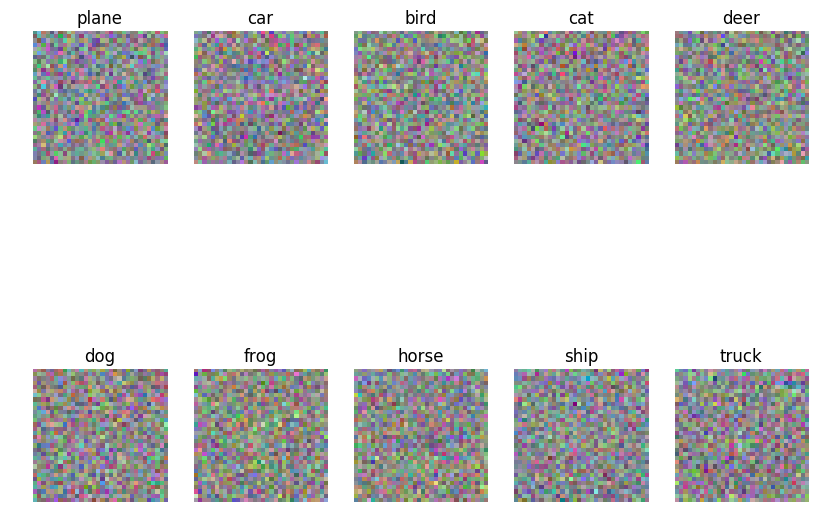

In [31]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])